Загружаем необходимые библиотеки

Data Science проект:
- Анализ данных
- Визуализация данных
- Предобработка данных
- Генерация новых признаков
- Построение модели
- Оценка качества
- Внедрение модели
- Мониторинг качества и улучшение модели

In [29]:
# импортирую основные библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [30]:
df = pd.read_csv('train.csv') # загружаю таблицу с данными

In [31]:
df.head(2) # проверяю загрузилось ли

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B,300009.450063


In [32]:
df.columns  # смортю какие есть названия свойств (фитчей)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

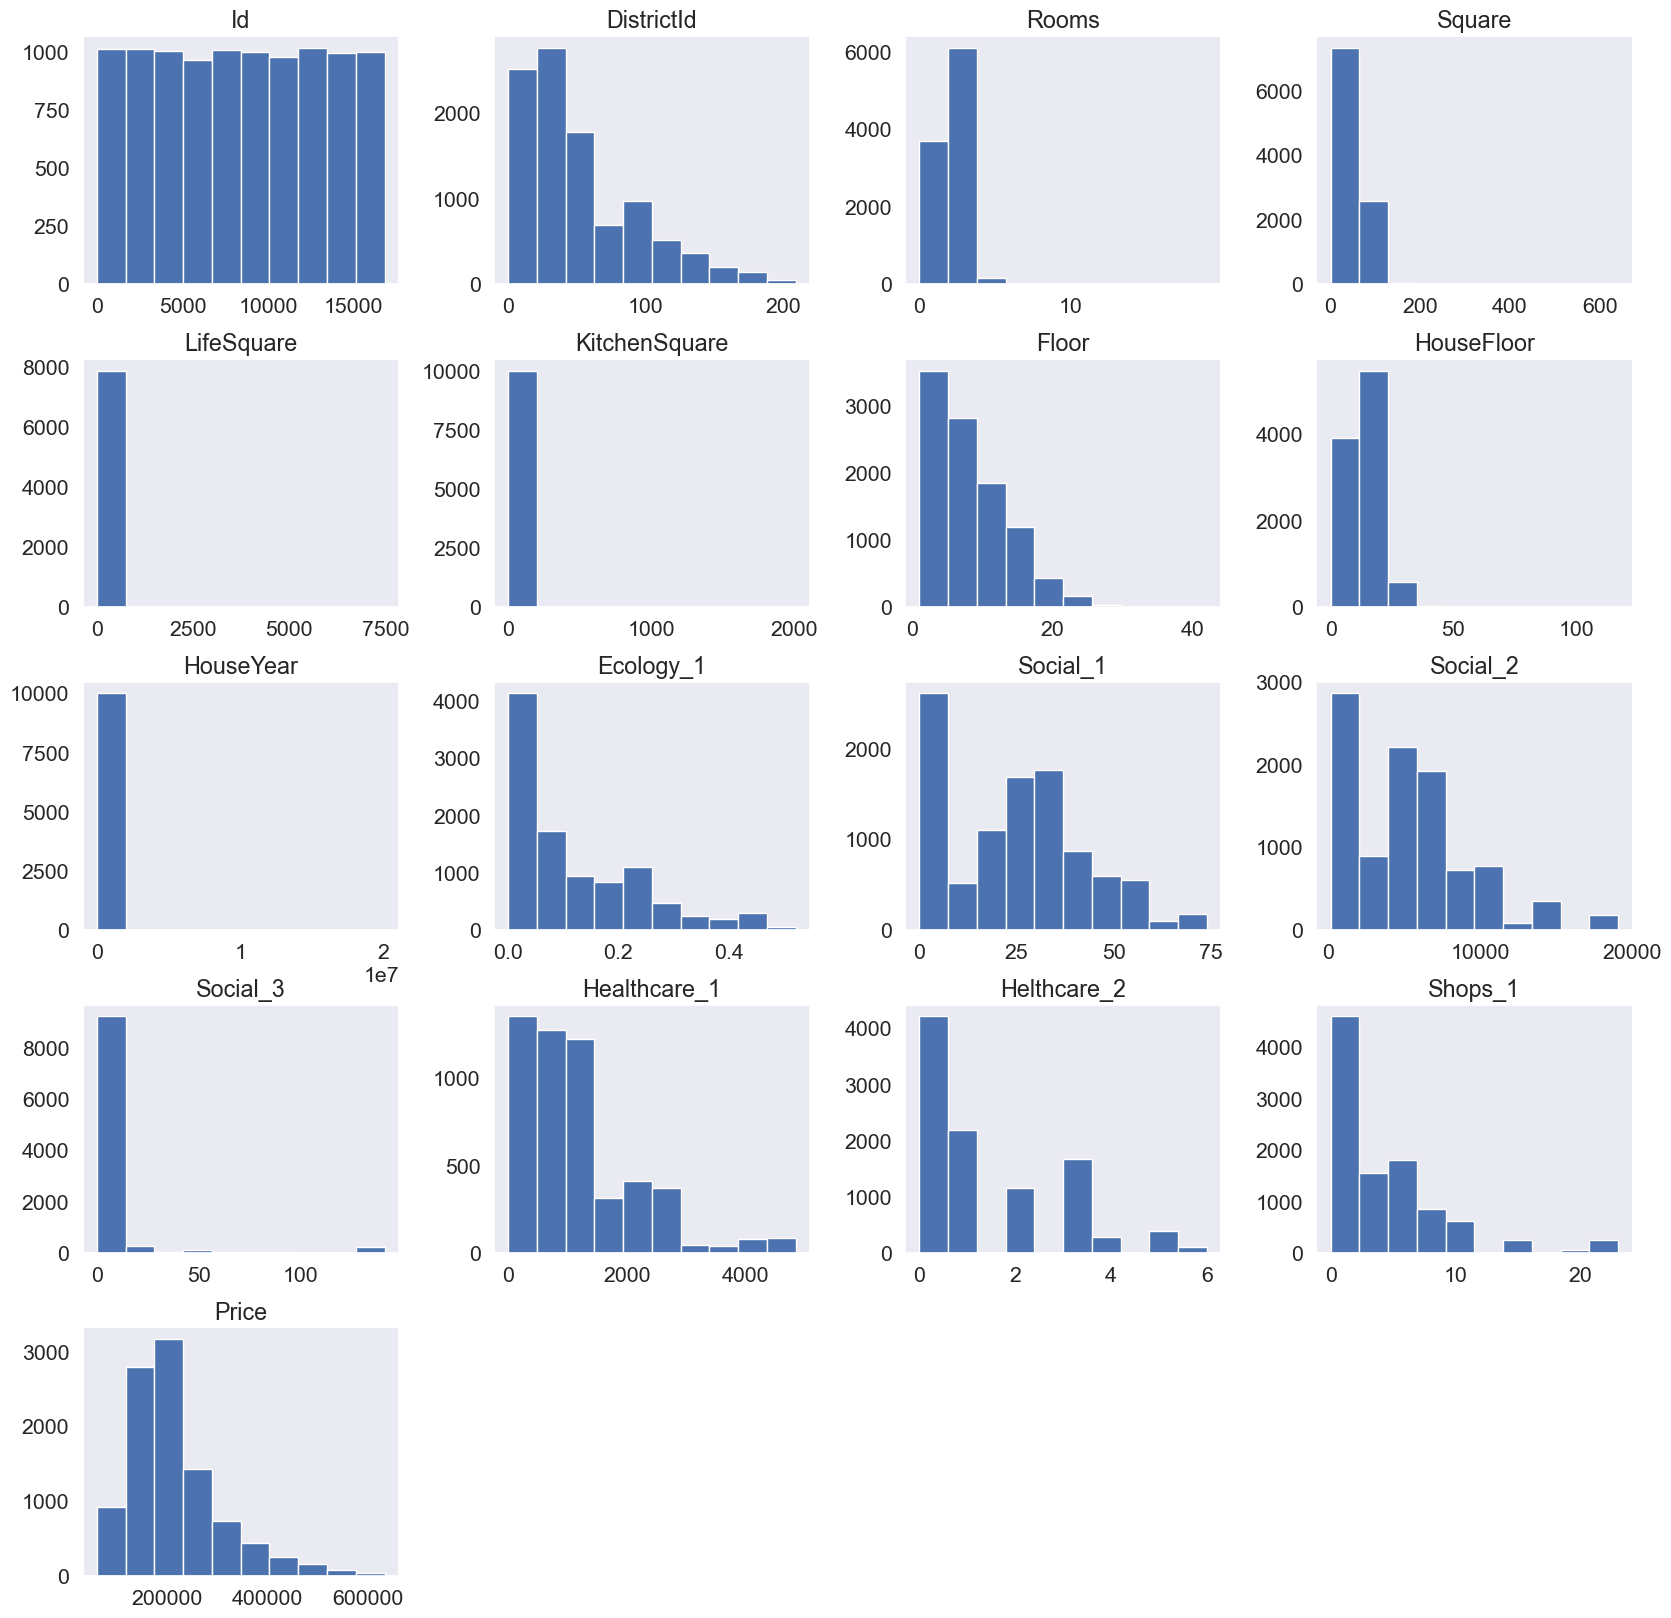

In [35]:
df_num_features = df.select_dtypes(include=['float64', 'int64']) # предварительный просмотр данных
df_num_features.hist(figsize=(20,20), grid=False);

Заметки по  анализу данных.
1. ID показатеь не информативный и его следует удалить
2. С показателм дистриктID (возможно номер региона) все очень сложно, т.к. это явно не числовое значетие а по сути код категориального признака. Вижу два пути решения проблемы: 1 исключить эти данные из расчета либо объединить в категориальные переменные по какомут-то признаку типа - (Москва не Россия :))
3. Комнаты - есть выбросы и по хорошему надо сопоставлять с общей площадью на адекватность данных и заменить оные сомнительные. с комнатами явно косяк особенно когда пятикомнатные квартиры общей площадью 42 кв метра 
4. Есть куча данных где общая площадь меньше жилой, по идее хорошо бы как-то сравнять показатели. 
4.1 !Жилая площадь с пропусками
5. С площадью кухни явный выброс т.к. выкинуло аж на 2000 при этом много 0 и 1 
6. По идее разметр кухни имеет значение но 0 кухня портит статистику стоит возможно разбить на тех у кого она есть и у кого ее нет? типа большая маленькая средняя и студия?
7. Этажность больш 25 вызывает большие сомнения 
8. Жилая площадь много где отутствует, по хорошему надо ее высчитывать. 
9. Квартиры явно зависят от этажа и по логике надо доп переменные ввести. Много этажей оказалось выше этажности дома. А еще бывает нулевая этажность дома 269 штук 
10. Эколоджи1 равный 0 думаю это пропуски из следует заменить на средние цифры. 
11. Социал 1 тоже куча нулей явно левых, которые надо замениь на средние. 
12. Социал 2 аналогичная ситуация, не понятны показатели вообще о чем они. 
13. Cоциал 3 странная штука, очень большой раброс, много 0, хорошо бы это все посмотреть на корреляцию признаков между собой, т.к. по логике они должны коррелировать и в идеале их в один признак бы объединить (понижение размерности) 
14. Выкинул бы хелфкаре1 т.к. много пропусков.
15. Эколоджи  шопс я бы перевел в бинарные признаки 0 и 1 где 0 - B а 1 - А 
16. Кстати сколько дому лет можно персчитать на количество лет жизни дома 

Анализ данных проводился при помощи методов:
df.info()
df.isna().sum()
df.X.describe() # где X - это значение своиств
plt.hist(df.X) # где X - это значение своиств
plt.show()
При этом использовались и более сложные условия проверки данных ан адекватность
df[(df.Price > 500000) & (df.Square<100)].head(50) (пример посика маленьких но очень дорогих квартир, вероятно неоправданно дорогих)

хорошо бы еще сравнить средние цены по регионам, тогда возможно идеи по группировке бы появились как использоать эти данные 

Предобработка данных

In [36]:
def data_processing(df):
    # 1. ID показатеь не информативный и его следует удалить
    df = df.drop(columns='Id')
    # Пока удалем и дистрикт. 
    df = df.drop(columns='DistrictId')
    # Посмотрев последний вебинар стало ясно, что удалять дистрикт не самая умная идея но я оставил как есть.
    # Мне кажется это некая махинация с данными, когда создавалсь новый набор данных с дистриктом и прайсами, т.к. на
    # тестовой моделе данных без прайса просто вылетит ошибка, к тому же явно прайс косвено оказался в списке независимых переменных,
    # что естесвенно повысило точность предсказания, однако это "ход конем".
    # Поскольку без дистрикта у меня посчитало на 60+, я все таки решил от него отказаться, хотя была идея кластеризации эти даннх
    
    # Првоедя кластеный анализ Района и Цены получилось, что оптимыальным было бы 5 класетров с точками по оси х (дситрикт):
    # 35, 47, 55, 70 и 80. В связи с этим думаю следует объединить дистрикт в 5   
    
    #array([[5.54795689e+01, 2.48821994e+05],
    #   [3.58189212e+01, 1.19750385e+05],
    #   [7.01825688e+01, 3.47877024e+05],
    #   [4.73696488e+01, 1.82300046e+05],
    #   [7.95829596e+01, 4.86965601e+05]])
    
    # но я решил оставить как есть, к тому же на корреляционной матрице дистрик вообще не коррелировал с ценой, я понимаю это не числовой показатель,
    # в общем есть над чем работать и куда расти :)
    
    
    # убираем неоправданно большое количество комнат и меняем на моду (2 комнаты)
    condition = df.Rooms > 5
    df.loc[condition, 'Rooms'] = 2 # тут всего 4 в дата сете по сути капля в море
    condition = (df.Rooms > 2) & (df.Square < 50)
    df.loc[condition, 'Rooms'] = 2 # а тут вопрос спорный насколко я прав при их исправлении, но больше десятка таких набралось
    # 0 комнат тоеж не есть хорошо, там то помещения со стадион, то собачья конура, всего 8 штук
    condition = df.Rooms == 0
    df.loc[condition, 'Rooms'] = 2 # поменяем на моду
    condition = df.Square < 10
    df.loc[condition, 'Square'] = df.loc[condition, 'Square']*10 # умножим на десять площадь квартир меньше 10
    condition = df.Square > 250        
    df.loc[condition, 'Square'] = df.loc[condition, 'Square']/10 # поделим на десять в случае когда площадь запредельная
    # Пропущенные знанения по жилой пощади, записываем занчения общей площади
    mean = df['LifeSquare'].mean()
    df['LifeSquare'] = df['LifeSquare'].fillna(df.Square)
    # Если вдруг площадь жилая больше общей записываем занчения общей площади
    condition = df.LifeSquare > df.Square 
    df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] #в идеале за вычетом кухни, но с кухней отдельная история 
    condition = df.LifeSquare < 20 
    df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] #в идеале за вычетом кухни, но с кухней отдельная история 
    condition = (df.KitchenSquare > 25) | (df.KitchenSquare <= 3)   # если кухня больше 25 пересчитаем зная общую и жилую
    df.loc[condition, 'KitchenSquare'] = df.loc[condition, 'Square']*0.15 #в идеале за вычетом кухни, но с кухней отдельная история 
    #condition = (df.KitchenSquare < 3) 
    #df.loc[condition, 'KitchenSquare'] = df.loc[condition, 'Square']*0.15 # делаем кухню с 20% от общей площади 
    condition = df.HouseFloor > 50
    df.loc[condition, 'HouseFloor'] = 12
    # нулевая этажность дома по сути отражает отсутвие инфы об этажности
    condition = df.HouseFloor == 0
    df.loc[condition, 'HouseFloor'] = df.loc[condition, 'Floor']
    # огромное количество данных где этаж не совпадает с этажностью дома 
    condition = df.HouseFloor < df.Floor 
    df.loc[condition, 'Floor'] = df.loc[condition, 'HouseFloor'] # делаем такое допущение, что это последний этаж
    condition = df.HouseYear > 2023
    df.loc[condition, 'HouseYear'] = 2000 
    df['HouseAge'] = 2023 - df['HouseYear']
    df = df.drop(columns='HouseYear') # вместо дога производсва дома заменил на годы жизни
    # что значит эколоджи 1 я не знаю поэтом оставлю как есть, а эко 2  и 3 переведу в бинарный формат
    condition = df.Ecology_2 == 'B'
    df.loc[condition, 'Ecology_2'] = 0
    condition = df.Ecology_2 == 'A'
    df.loc[condition, 'Ecology_2'] = 1
    df['Ecology_2'] = pd.Series(df['Ecology_2'], dtype=int)

    condition = df.Ecology_3 == 'B'
    df.loc[condition, 'Ecology_3'] = 0
    condition = df.Ecology_3 == 'A'
    df.loc[condition, 'Ecology_3'] = 1
    condition = df.Ecology_3 == 'B'
    df['Ecology_3'] = pd.Series(df['Ecology_3'], dtype=int)

    df.loc[df.Shops_2 == 'B', 'Shops_2'] = 0
    df.loc[df.Shops_2 == 'A', 'Shops_2'] = 1
    df['Shops_2'] = pd.Series(df['Shops_2'], dtype=int)

    # возможно не самый корректный способ избавления от пропуска, но ничего другого не придумалось пока (превратил в средние занчения)
    mean = df['Healthcare_1'].mean()
    df['Healthcare_1'] = df['Healthcare_1'].fillna(mean)
               
    return df    
    

In [37]:
n_df = data_processing(df)

In [38]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [39]:
n_df = reduce_mem_usage(n_df)

Memory usage of dataframe is 1.26 MB
Memory usage after optimization is: 0.42 MB
Decreased by 66.7%


In [40]:
n_df.info() # проверяем несколько хорошо избавились от категориальных переменных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          10000 non-null  float32
 1   Square         10000 non-null  float32
 2   LifeSquare     10000 non-null  float32
 3   KitchenSquare  10000 non-null  float32
 4   Floor          10000 non-null  int8   
 5   HouseFloor     10000 non-null  float32
 6   Ecology_1      10000 non-null  float32
 7   Ecology_2      10000 non-null  int8   
 8   Ecology_3      10000 non-null  int8   
 9   Social_1       10000 non-null  int8   
 10  Social_2       10000 non-null  int16  
 11  Social_3       10000 non-null  int16  
 12  Healthcare_1   10000 non-null  float32
 13  Helthcare_2    10000 non-null  int8   
 14  Shops_1        10000 non-null  int8   
 15  Shops_2        10000 non-null  int8   
 16  Price          10000 non-null  float32
 17  HouseAge       10000 non-null  int8   
dtypes: floa

Визуализация данных прошедших предобработку и оптимизацию

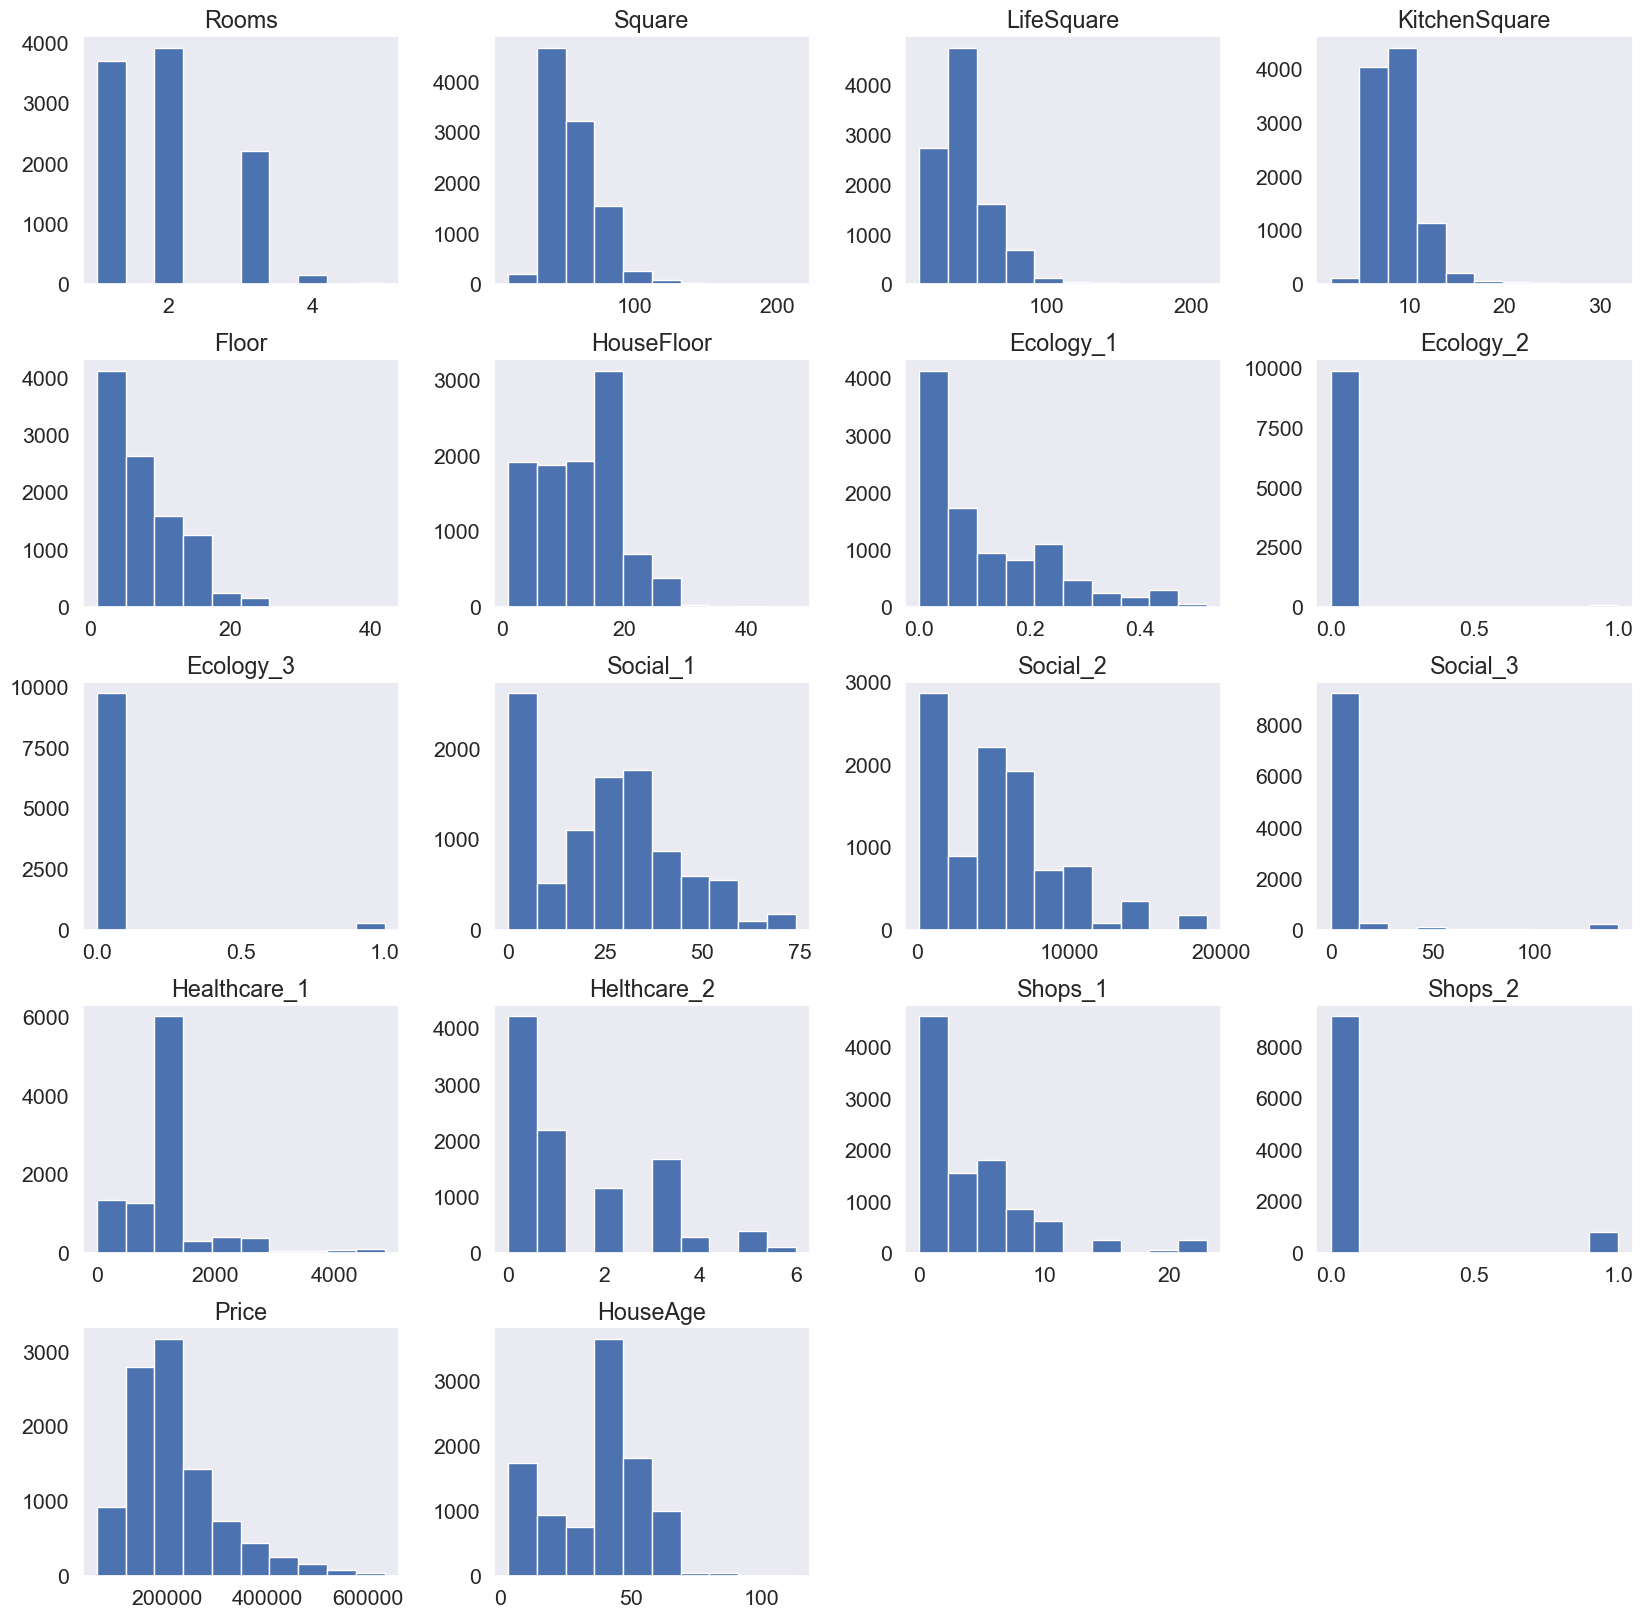

In [41]:
df_num_features = n_df.select_dtypes(include=['float32', 'int8', 'int16'])
df_num_features.hist(figsize=(20,20), grid=False);

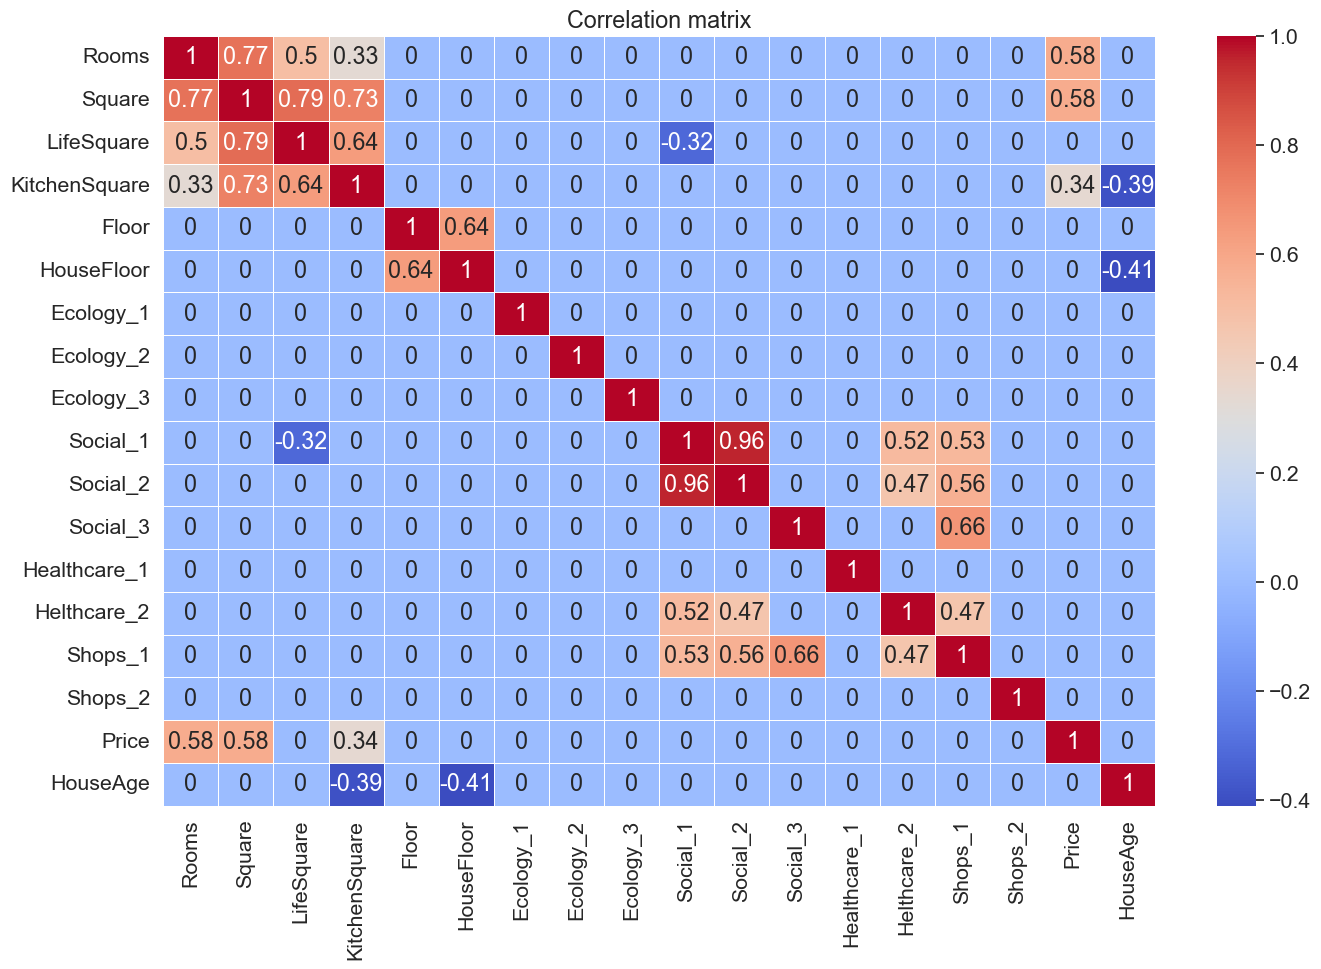

In [42]:

plt.figure(figsize = (16,10))

sns.set(font_scale=1.4)

corr_matrix = n_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [43]:
# поскольку показатели социал 1 и социал 2 пактически линейно зависимы между собой, один из них думаю следует дропнуть 
n_df = n_df.drop(columns='Social_2') 
# корреляционная матрица говорит о том, что на цену вляет количество комнат и общая площадь квартиры ну и кухни немного. 
# странно, что год жизни дома вообще не коррелирует с ценой на жилье. В более новых домах больше кухня и этажность. 


Построение модели

In [44]:
# NB перед построением модели думаю следует нормализовать или стандартизировать данные.  

# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2


In [45]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'HouseAge']

target_name = 'Price'

# общую базу данных разделям на таргет и свойства 
f_df = n_df[feature_names]
t_df = n_df[target_name]


Стандартизация признаков

In [46]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) -> [0, 1]
# StandardScaler() Для каждой фичи х делает: (x - mean) / std      -> mean = 0, std = 1

scaler = MinMaxScaler()
stand_features = scaler.fit_transform(f_df)


In [47]:
f_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
f_df.head(3)

C:\Users\SaaS\AppData\Local\Temp\ipykernel_11572\2192752996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge
0,0.25,0.181645,0.090433,0.142046,0.146341,0.170213,0.170618,0.0,0.0,0.445946,0.035461,0.235699,0.000000,0.478261,0.0,0.463636
1,0.50,0.269468,0.143503,0.208196,0.146341,0.170213,0.000134,0.0,0.0,0.621622,0.007092,0.049495,0.166667,0.695652,0.0,0.381818
2,0.25,0.166594,0.089206,0.166594,0.170732,0.234043,0.095115,0.0,0.0,0.459459,0.000000,0.047226,0.166667,0.130435,0.0,0.472727


Разбиение на train / test

In [48]:
X = f_df
y = t_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

Построение модели линейной регрессии

In [49]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [50]:
y_pred = lr_model.predict(X_test)
print (r2(y_test, y_pred), mse(y_test, y_pred))

0.49853349057424234 4417863000.0


In [20]:
y_pred = lr_model.predict(X_train)
r2(y_train, y_pred) # даже на тренировочных данных модель показала меньше 52, что уж говорит про тестовые, но по сути это не 
# удивительно, т.к. линейная регрессия и корреляция вещи очень похожие. 

0.5183281942429161

Полиномиальная регрессия

In [51]:
from sklearn.preprocessing import PolynomialFeatures
pf=PolynomialFeatures()     
X_poly=pf.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, shuffle=True, random_state=42)

lr_model.fit(X_train, y_train)

print('Результаты на тренировочных данных')
y_pred = lr_model.predict(X_train)
print (r2(y_train, y_pred), mse(y_train, y_pred))

print('Результаты на проверочных данных')
y_pred = lr_model.predict(X_test)
print (r2(y_test, y_pred), mse(y_test, y_pred))

Результаты на тренировочных данных
0.6784220967334758 2753509400.0
Результаты на проверочных данных
0.6148749949505239 3392907300.0


Полиномиальная регрессия справилась с поставленной задачей! Что говорит о том, что закономерность более сложная чем прямая линия (линейная регресия). 
Как бы то ни было было решено проверить модель деревьевь решений: 

Деревья решений (поскольку на них не нужна стандартизация признаков, то возпользуемся не сандартизированными)

In [22]:
X = n_df[feature_names]
y = n_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [23]:
dt_model = DecisionTreeRegressor(criterion='squared_error', max_depth=10, min_samples_leaf=10, random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

In [24]:
print('Результаты на тренировочных данных')
y_pred = dt_model.predict(X_train)
print (r2(y_train, y_pred), mse(y_train, y_pred))

print('Результаты на проверочных данных')
y_pred = dt_model.predict(X_test)
print (r2(y_test, y_pred), mse(y_test, y_pred))

Результаты на тренировочных данных
0.7658574164295274 2004844930.226703
Результаты на проверочных данных
0.6320496514269272 3241600669.7031164


In [52]:
test_df = pd.read_csv('test.csv')
test_df.head() 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [53]:
t_df = data_processing(test_df)
t_df = t_df.drop(columns='Social_2') # по хорошему я бы эту строку перенес в педобработку, но, чтобы сохранилась логика моих действий, отсавил так.
t_df.head(2)


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge
0,2.0,49.882643,33.432782,6.000000,6,14.0,0.310199,0,0,11,1,1146.657263,0,0,0,51
1,2.0,69.263183,69.263183,10.389478,1,1.0,0.075779,0,0,6,3,1146.657263,0,2,0,46


In [54]:
# поскольку оптимальной моделью оказалась дерево решиений применим на тестовых данных ее (без стандартизации данных). 
X = t_df
y_pred = dt_model.predict(X)

y_pred = pd.DataFrame(y_pred, columns=['Price'])
y_pred.head(10)

#y_pred.to_csv('test_pred_price.csv') # сохраняем спрогнозированные результаты в файл test_pred_price.csv

,Price
0,158696.780350
1,184790.217634
2,194653.586979
3,323140.489769
4,127968.490702
5,198214.805948
6,161981.308494
7,193139.330435
8,323140.489769
9,210883.672423
